In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from birdclef.spark import get_spark
from pyspark.sql import functions as F
from matplotlib import pyplot as plt
from pacmap import PaCMAP
import numpy as np
from pathlib import Path

In [3]:
spark = get_spark(cores=8, memory="20g")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/24 23:09:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/24 23:09:24 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [4]:
root = Path("~/shared/birdclef/2025").expanduser()
! tree -L 4 {root}

/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/2025
├── infer-soundscape
│   ├── BirdNET
│   │   ├── parts
│   │   │   ├── embed
│   │   │   ├── predict
│   │   │   └── timing
│   │   └── _SUCCESS
│   ├── BirdSetConvNeXT
│   │   ├── parts
│   │   │   ├── embed
│   │   │   ├── predict
│   │   │   └── timing
│   │   └── _SUCCESS
│   ├── BirdSetEfficientNetB1
│   │   ├── parts
│   │   │   ├── embed
│   │   │   ├── predict
│   │   │   └── timing
│   │   └── _SUCCESS
│   ├── HawkEars
│   │   ├── parts
│   │   │   ├── embed
│   │   │   ├── predict
│   │   │   └── timing
│   │   └── _SUCCESS
│   ├── Perch
│   │   ├── parts
│   │   │   ├── embed
│   │   │   ├── predict
│   │   │   └── timing
│   │   └── _SUCCESS
│   └── RanaSierraeCNN
│       ├── parts
│       │   ├── embed
│       │   ├── predict
│       │   └── timing
│       └── _SUCCESS
└── infer-soundscape-cpu
    ├── BirdNET
    │   ├── parts
    │   │   ├── embed
    │   │   ├── predict
    │   │   └── timing
    │   └── _SUCCESS
  

Let's compare inference time.

In [5]:
def summarize_timings(path):
    print(path)
    df = spark.read.json(path)
    df.agg(F.sum("elapsed") / 3600, F.mean("elapsed"), F.count("elapsed")).show()


summarize_timings(f"{root}/infer-soundscape-cpu/BirdNET/parts/timing")
summarize_timings(f"{root}/infer-soundscape/BirdNET/parts/timing")
summarize_timings(f"{root}/infer-soundscape-cpu/Perch/parts/timing")
summarize_timings(f"{root}/infer-soundscape/Perch/parts/timing")

/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/2025/infer-soundscape-cpu/BirdNET/parts/timing


+---------------------+------------------+--------------+
|(sum(elapsed) / 3600)|      avg(elapsed)|count(elapsed)|
+---------------------+------------------+--------------+
|    5.929498420328503|106.73097156591307|           200|
+---------------------+------------------+--------------+

/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/2025/infer-soundscape/BirdNET/parts/timing
+---------------------+------------------+--------------+
|(sum(elapsed) / 3600)|      avg(elapsed)|count(elapsed)|
+---------------------+------------------+--------------+
|    5.943208431618469|106.97775176913245|           200|
+---------------------+------------------+--------------+

/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/2025/infer-soundscape-cpu/Perch/parts/timing
+---------------------+-----------------+--------------+
|(sum(elapsed) / 3600)|     avg(elapsed)|count(elapsed)|
+---------------------+-----------------+--------------+
|    53.14476255857981|956.6057260544366|           200|


BirdNET is pretty much only a CPU model, so even when we have a GPU available it will run on the CPU. I'm not sure it's worthwhile to squeeze any more performance out of it since it's already such a good model.

In [7]:
models = [
    "BirdNET",
    "Perch",
    "HawkEars",
    "BirdSetConvNeXT",
    "BirdSetEfficientNetB1",
    "RanaSierraeCNN",
]
for model in models:
    summarize_timings(f"{root}/infer-soundscape/{model}/parts/timing")

/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/2025/infer-soundscape/BirdNET/parts/timing
+---------------------+------------------+--------------+
|(sum(elapsed) / 3600)|      avg(elapsed)|count(elapsed)|
+---------------------+------------------+--------------+
|    5.943208431618469|106.97775176913245|           200|
+---------------------+------------------+--------------+

/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/2025/infer-soundscape/Perch/parts/timing
+---------------------+------------------+--------------+
|(sum(elapsed) / 3600)|      avg(elapsed)|count(elapsed)|
+---------------------+------------------+--------------+
|   1.4635799102767164|26.344438384980894|           200|
+---------------------+------------------+--------------+

/storage/home/hcoda1/8/amiyaguchi3/shared/birdclef/2025/infer-soundscape/HawkEars/parts/timing
+---------------------+------------------+--------------+
|(sum(elapsed) / 3600)|      avg(elapsed)|count(elapsed)|
+--------------------

Let's look at the embedding spaces and see if they make _any_ sense.

In [8]:
@F.udf("array<float>")
def mean_udf(arr):
    return np.mean(arr, axis=0).tolist()


def read_embeddings(path):
    df = spark.read.parquet(path)
    return df.select(
        *df.columns[:3],
        F.array(*df.columns[3:]).alias("embeddings"),
    )


def average_embeddings(df):
    return (
        df.groupBy("file")
        .agg(mean_udf(F.collect_list("embeddings")).alias("embeddings"))
        .orderBy("file")
    )


birdnet = read_embeddings(f"{root}/infer-soundscape-cpu/BirdNET/parts/embed")
birdnet.printSchema()
birdnet.show(n=3, vertical=True, truncate=100)
avg_birdnet = average_embeddings(birdnet).cache()
avg_birdnet.select("file").distinct().count()
avg_birdnet.select(F.size("embeddings")).distinct().show()

root
 |-- file: string (nullable = true)
 |-- start_time: double (nullable = true)
 |-- end_time: double (nullable = true)
 |-- embeddings: array (nullable = false)
 |    |-- element: float (containsNull = true)



25/04/24 23:16:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0----------------------------------------------------------------------------------------------------------
 file       | /storage/coda1/p-dsgt_clef2025/0/shared/birdclef/raw/birdclef-2025/train_soundscapes/H02_20230506... 
 start_time | 0.0                                                                                                  
 end_time   | 3.0                                                                                                  
 embeddings | [0.04160746, 0.0, 0.816704, 1.6265234, 0.0, 0.1433202, 0.059183758, 0.073363304, 0.031847376, 0.0... 
-RECORD 1----------------------------------------------------------------------------------------------------------
 file       | /storage/coda1/p-dsgt_clef2025/0/shared/birdclef/raw/birdclef-2025/train_soundscapes/H02_20230506... 
 start_time | 3.0                                                                                                  
 end_time   | 6.0                                                       

+----------------+
|size(embeddings)|
+----------------+
|            1024|
+----------------+



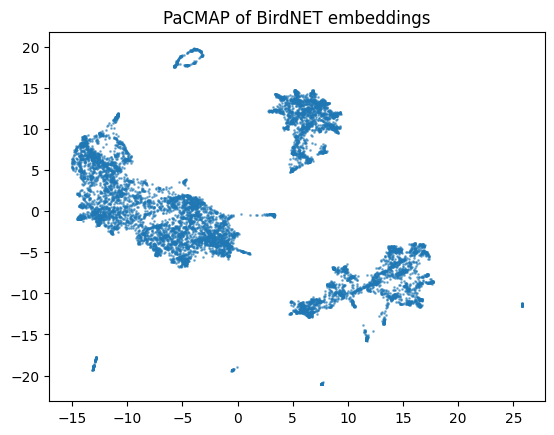

In [9]:
def plot_embeddings(df, title, color=None):
    pdf = df.toPandas()
    X = np.stack(pdf.embeddings.values)
    reducer = PaCMAP(n_components=2)
    g = reducer.fit_transform(X)
    kwargs = {}
    if color is not None:
        kwargs["c"] = color
    plt.scatter(g[:, 0], g[:, 1], s=1, alpha=0.5, **kwargs)
    plt.title(title)
    plt.show()


plot_embeddings(avg_birdnet, "PaCMAP of BirdNET embeddings")

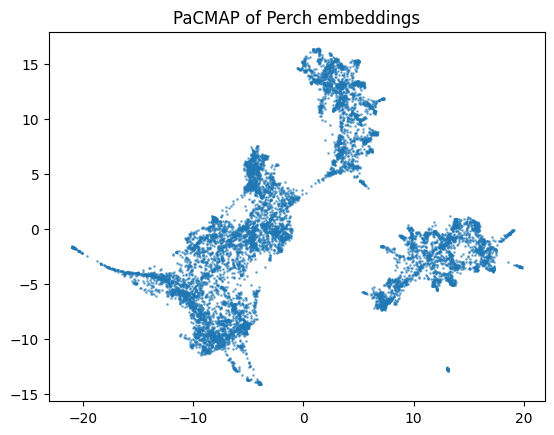

In [10]:
perch = read_embeddings(f"{root}/infer-soundscape-cpu/Perch/parts/embed")
avg_perch = average_embeddings(perch).cache()
plot_embeddings(avg_perch, "PaCMAP of Perch embeddings")

In [11]:
pdf = avg_birdnet.toPandas()
X = np.stack(pdf.embeddings.values)
reducer = PaCMAP(n_components=1)
# color g with dim 1
c_g_d1 = reducer.fit_transform(X)

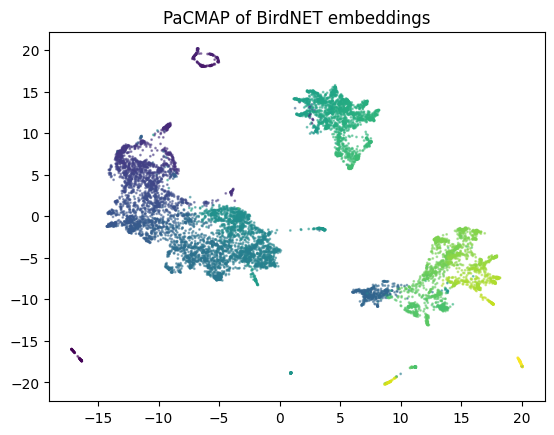

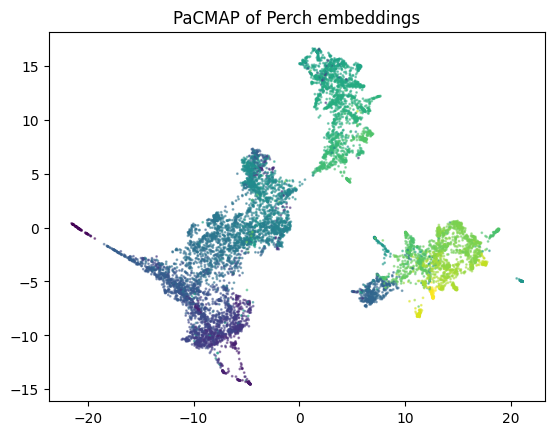

In [12]:
plot_embeddings(avg_birdnet, "PaCMAP of BirdNET embeddings", color=c_g_d1)
plot_embeddings(avg_perch, "PaCMAP of Perch embeddings", color=c_g_d1)

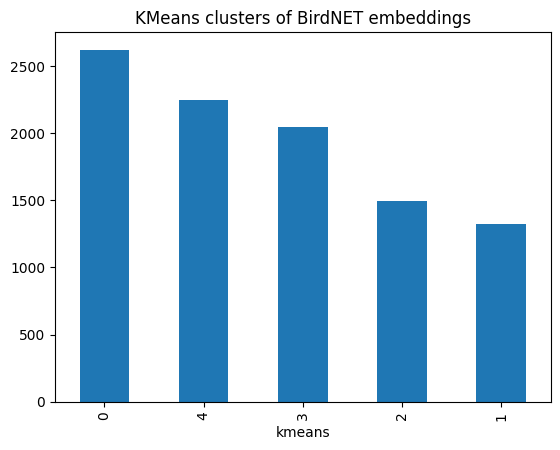

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
pdf["kmeans"] = kmeans.labels_
pdf["kmeans"].value_counts().plot(kind="bar")
plt.title("KMeans clusters of BirdNET embeddings")
plt.show()

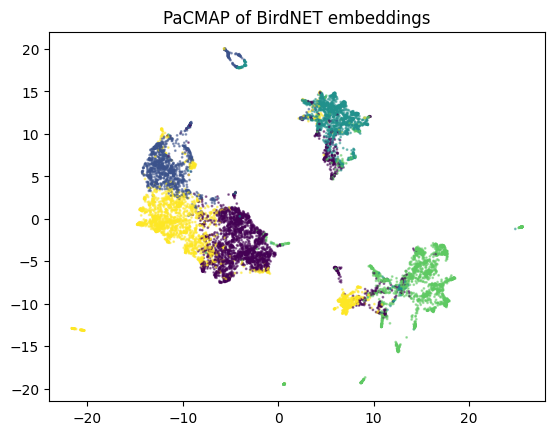

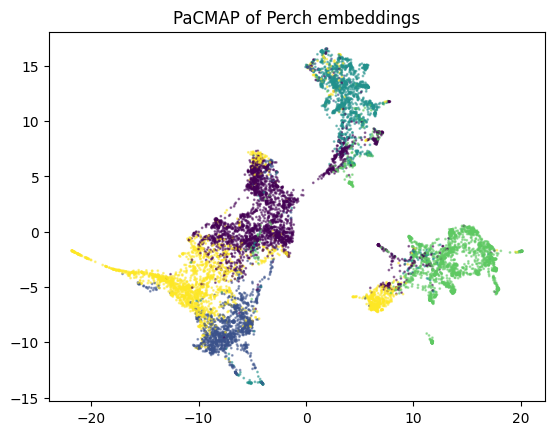

In [14]:
# plot the cluster as a color
plot_embeddings(avg_birdnet, "PaCMAP of BirdNET embeddings", color=pdf["kmeans"])
plot_embeddings(avg_perch, "PaCMAP of Perch embeddings", color=pdf["kmeans"])

['BirdNET',
 'Perch',
 'HawkEars',
 'BirdSetConvNeXT',
 'BirdSetEfficientNetB1',
 'RanaSierraeCNN']

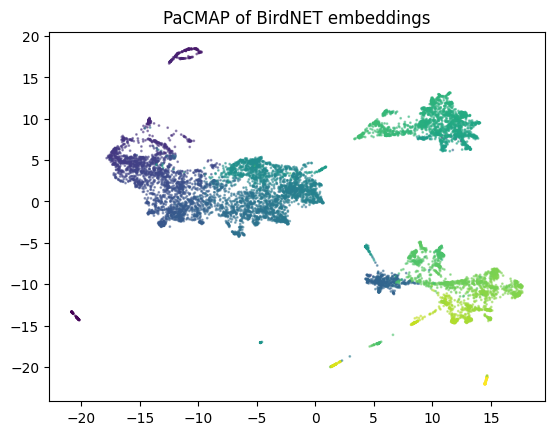

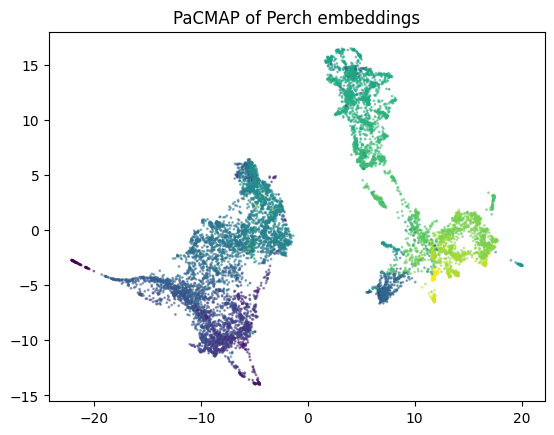

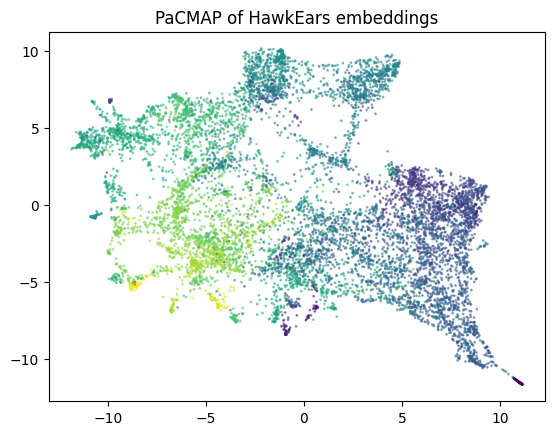

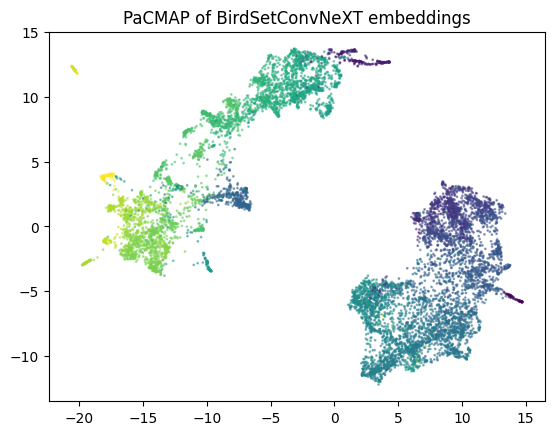

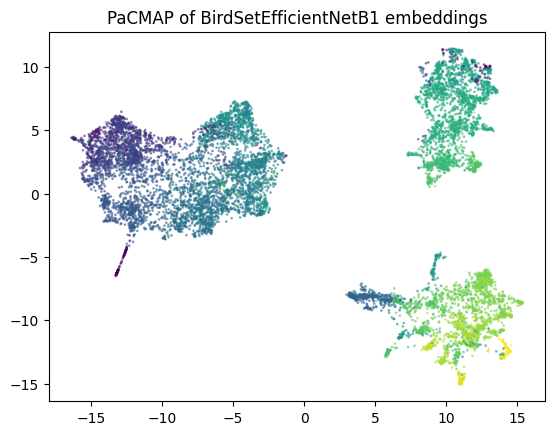

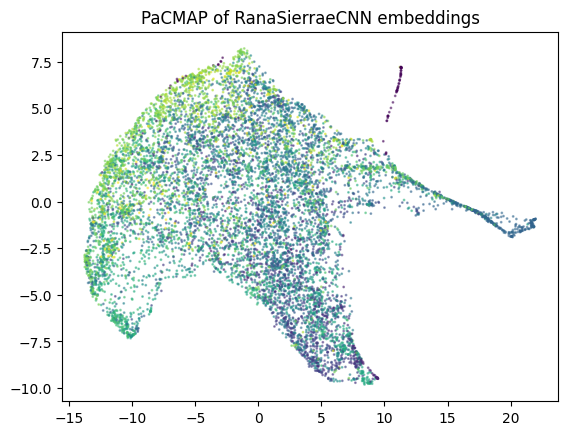

In [15]:
# now let's run this for all models
display(models)
embeddings = {}
for model in models:
    df = read_embeddings(f"{root}/infer-soundscape/{model}/parts/embed")
    avg = average_embeddings(df).cache()
    embeddings[model] = avg

for model in models:
    plot_embeddings(embeddings[model], f"PaCMAP of {model} embeddings", color=c_g_d1)